# **Background texture characterization in OSTEM**
---
#### Overview
- OSTEM images have added background texture from the substrate
- Here, we analyze this background texture using OSTEM, BSD and SE images from the substrate surface of three different scintillator screens
- We use lineplots to estimate the intensity profile and calculate the variation in intensity due to the dopant concentration differences


In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pathlib import Path
from skimage import img_as_float
from skimage.util import invert
from scipy.ndimage import gaussian_filter
import tifffile as tf
import pandas as pd
from tqdm.notebook import tqdm

## 1. Import data
---

In [2]:
# Find directory
DATA_dir = Path("../data/6_Supplementary/Background_texture_analysis_40x")

# Select files and initialize DataFrame with image locations
df_im = pd.DataFrame({'FilePos': list(DATA_dir.glob('*/*/*.tif'))})

# Build up DataFrame
df_im['Scintillator'] = df_im['FilePos'].apply(lambda x: x.parents[1].name)
df_im['Area'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[5].split('.tif')[0])
df_im['DetectionMode'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[0])
df_im['LE'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[1].split('kV')[0])
df_im['Dwell'] =  df_im['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# List values in ascending order
df_im['Dwell'] = df_im['Dwell'].astype(float)
df_im.sort_values(['Scintillator', 'Area','DetectionMode'], inplace=True)
df_im.reset_index(inplace=True, drop=True)

# Preview
df_im.head(5)

,FilePos,Scintillator,Area,DetectionMode,LE,Dwell
0,..\data\6_Supplementary\Background_texture_ana...,scint1,000,BSD,4,10000.0
1,..\data\6_Supplementary\Background_texture_ana...,scint1,000,OSTEM,4,10000.0
2,..\data\6_Supplementary\Background_texture_ana...,scint1,000,SE,4,10000.0
3,..\data\6_Supplementary\Background_texture_ana...,scint1,001,BSD,4,10000.0
4,..\data\6_Supplementary\Background_texture_ana...,scint1,001,OSTEM,4,10000.0


## 2. Side by side comparison of substrate surface with detectors
---

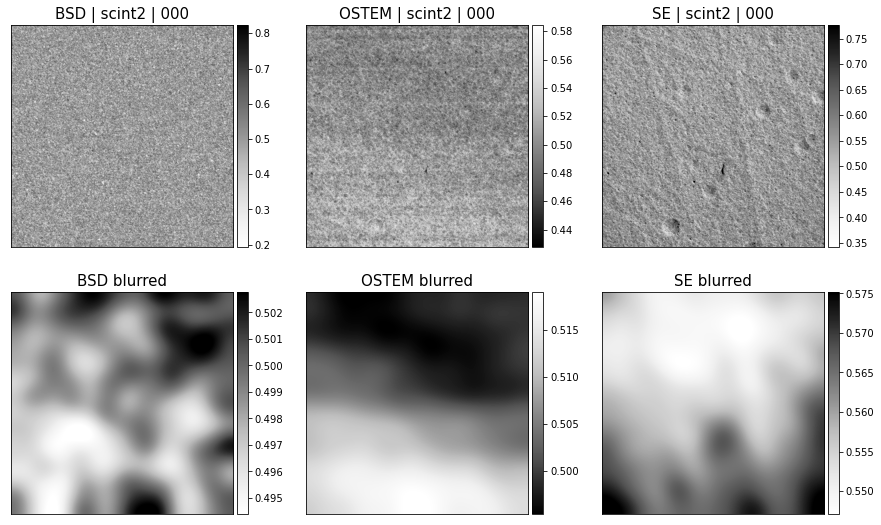

In [217]:
# Show images from scintillator 1
fig, ax = plt.subplots(2, 3, figsize=(15, 9))
plot_im = df_im.loc[12:14].reset_index() # First two images
for index, row in plot_im.iterrows():
    image = img_as_float(tf.imread(row['FilePos'].as_posix()))[34:1735, 174:1875]
    # Blur
    image_blur = gaussian_filter(image, sigma=100)

    hi_im = np.percentile(image, 99)
    low_im = np.percentile(image, 1)
    hi_blur = np.percentile(image_blur, 99)
    low_blur = np.percentile(image_blur, 1)
    if row['DetectionMode'] == 'OSTEM':
        cmap = 'Greys_r'
    else:
        cmap = 'Greys'
    im1 = ax[0][index].imshow(image, cmap=cmap, vmin=low_im, vmax=hi_im) # OSTEM
    ax[0][index].set_title(f"{row['DetectionMode']} | {row['Scintillator']} | {row['Area']}", fontsize=15)
    im2 = ax[1][index].imshow(image_blur, cmap=cmap, vmin=low_blur, vmax=hi_blur) # OSTEM
    ax[1][index].set_title(f"{row['DetectionMode']} blurred", fontsize=15)

    ax[0][index].set_xticks([])
    ax[1][index].set_xticks([])
    ax[0][index].set_yticks([])
    ax[1][index].set_yticks([])

    # Colorbar 1
    divider = make_axes_locatable(ax[0][index])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    # Colorbar 2
    divider = make_axes_locatable(ax[1][index])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

plt.savefig('images_scintillator_surface.png', dpi=300, bbox_inches='tight')

## 3. Background texture comparison between detectors
---
- After blurring out the surface defects, we see that the SE and BSD image retain a "random" intensity distribution, whereas the OSTEM image shows a clear profile. We attribute this to differences in doping concentration. 

Text(0.5, 1.0, 'Average line profile (y)')

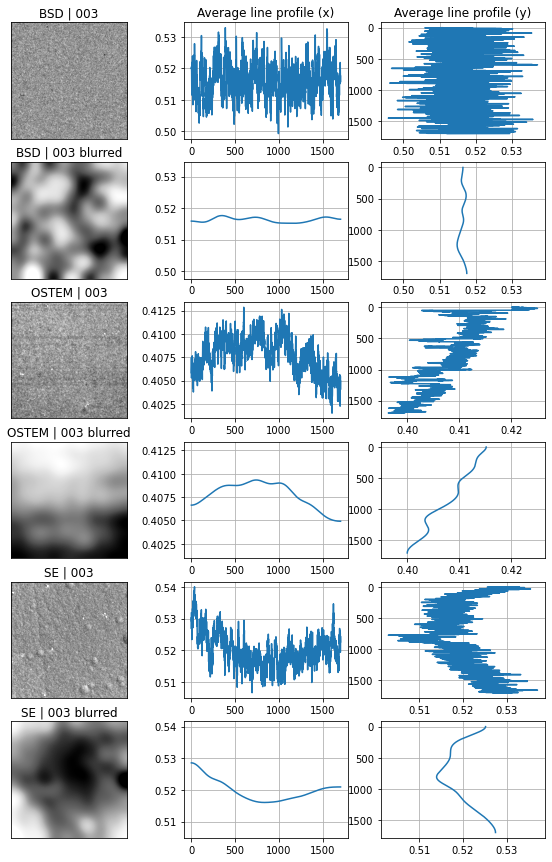

In [4]:
# Blur image and calculate line plots, show result beforehand and afterhand

fig, ax = plt.subplots(6, 3, figsize=(10, 15))
for i, row in df_im.loc[33:].reset_index().iterrows():
    image = img_as_float(tf.imread(row['FilePos'].as_posix()))[34:1735, 174:1875]
    if row['DetectionMode'] == 'OSTEM': # invert
        image = invert(image)
    # Blur
    image_blur = gaussian_filter(image, sigma=100)

    # Compute line plots
    lp_image = [np.mean(image, axis=0), np.mean(image, axis=1)] # Up-down, left_right
    lp_image_blur = [np.mean(image_blur, axis=0), np.mean(image_blur, axis=1)] # Up-down, left_right
    hi, low = np.percentile(image, 99), np.percentile(image, 1)
    hi_b, low_b = np.percentile(image_blur, 99), np.percentile(image_blur, 1)

    # Plot
    ax[2*i][0].imshow(image, cmap='Greys_r', vmin=low, vmax=hi) 
    ax[2*i+1][0].imshow(image_blur, cmap='Greys_r', vmin=low_b, vmax=hi_b) 
    ax[2*i][1].plot(lp_image[0])
    ax[2*i][2].plot(lp_image[1], np.arange(len(lp_image[1]))) # invert axes
    ax[2*i+1][1].plot(lp_image_blur[0])
    ax[2*i+1][2].plot(lp_image_blur[1], np.arange(len(lp_image_blur[1]))) # invert axes
    
    # Aesthetics
    # Grid
    ax[2*i][1].grid('on')
    ax[2*i][2].grid('on')
    ax[2*i+1][1].grid('on')
    ax[2*i+1][2].grid('on')
    
    # Share axes
    ax[2*i+1][1].sharey(ax[2*i][1])
    ax[2*i+1][2].sharex(ax[2*i][2])

    # Invert y axis
    ax[2*i][2].set_ylim(ax[2*i][2].get_ylim()[::-1])
    ax[2*i+1][2].set_ylim(ax[2*i+1][2].get_ylim()[::-1])

    # Set recurring subplot titles
    ax[2*i][0].set_title(f"{row['DetectionMode']} | {row['Area']}")
    ax[2*i+1][0].set_title(f"{row['DetectionMode']} | {row['Area']} blurred")

    # Turn of ticks for image
    ax[2*i][0].set_xticks([])
    ax[2*i][0].set_yticks([])
    ax[2*i+1][0].set_xticks([])
    ax[2*i+1][0].set_yticks([])                 

# Set one-time subplot titles
ax[0][1].set_title(f"Average line profile (x)")
ax[0][2].set_title(f"Average line profile (y)")


## 4. Analyze all images
- Calculate statistics for every OSTEM image, group per scintillator
- Box plot

In [22]:
# Data
source = df_im[df_im['DetectionMode'] == 'OSTEM']
df_stats = pd.DataFrame(columns=["scintillator", "area", "Imax", "Imin", "Imean", "Istd", "Imax-Imin/Imean (%)", "Isdt / Imean (%)"])
images = []
# Analyze images
for j, (scint, grp) in tqdm(enumerate(source.groupby(by=['Scintillator'])), total=3):
    images_scint = []
    for i, row in tqdm(grp.reset_index().iterrows(), total=4):
        image = img_as_float(tf.imread(row['FilePos'].as_posix()))[34:1735, 174:1875]
        # Blur
        image_blur = gaussian_filter(image, sigma=100)
        image_blur = image_blur.flatten()
        images_scint.append(image_blur)

        Imax = image_blur.max()
        Imin = image_blur.min()
        Imean = image_blur.mean()
        Istd = image_blur.std()
        df_stats = pd.concat([df_stats, pd.DataFrame([[scint, row['Area'], round(Imax, 4), round(Imin, 4), 
                                                       round(Imean, 4), round(Istd, 4), round(100 * (Imax-Imin) / Imean, 2), round(100 * Istd / Imean, 2)]], columns=df_stats.columns)])
    # Append
    images.append(images_scint)
df_stats.to_csv('scint_data.csv')
df_stats.groupby('scintillator')\
        .apply(lambda x: x[::len(df_stats)//2])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,scintillator,area,Imax,Imin,Imean,Istd,Imax-Imin/Imean (%),Isdt / Imean (%)
0,scint3,003,0.6012,0.5834,0.5922,0.0048,3.01,0.8
0,scint2,003,0.5157,0.4877,0.5008,0.0065,5.59,1.3
0,scint3,002,0.6056,0.5904,0.597,0.0033,2.55,0.55


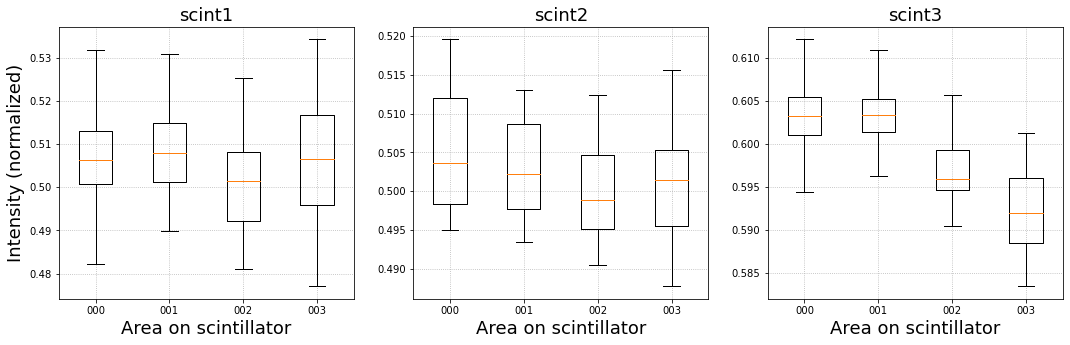

In [215]:
fs = 18

# Make figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = source['Area'].unique()
scintillator = ['scint1','scint2','scint3']
for j, images_per_scint in enumerate(images):
    # Plot boxplot
    axes[j].boxplot(images_per_scint, labels=labels, showfliers=False)  
    axes[j].set_title(scintillator[j], fontsize=fs) 
    axes[j].grid(which='both', ls=':') 
    axes[j].set_xlabel('Area on scintillator', fontsize=fs)

# Axes aesthetics
axes[0].set_ylabel('Intensity (normalized)', fontsize=fs)
for ax in axes:
    ax.set_ylim()
# plt.tight_layout()    
# plt.savefig('intensity_scintillators_boxplots', dpi=150, bbox_inches='tight')